# Analysis of tips received for Jan 2013 taxi trips

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import csv
import sqlite3
import time
from sklearn import cluster
from sklearn import feature_selection, linear_model
from mpl_toolkits.basemap import Basemap
from geopy.distance import vincenty, great_circle
import statsmodels.formula.api as smf

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

In [2]:
sample_trips_df = pd.read_csv('../nyc_taxi_files/2013_Jan_sample_nbrhd.csv')

In [3]:
sample_trips_df.columns

Index([u'medallion', u'hack_license', u'vendor_id', u'rate_code',
       u'store_and_fwd_flag', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'trip_time_in_secs', u'trip_distance',
       u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude',
       u'dropoff_latitude', u'payment_type', u'fare_amount', u'surcharge',
       u'mta_tax', u'tip_amount', u'tolls_amount', u'total_amount',
       u'pickup_hour', u'dropoff_hour', u'pickup_wday', u'pickup_day',
       u'full_date', u'neighborhood'],
      dtype='object')

In [4]:
log_tips = sample_trips_df['tip_amount'].apply(np.log)

In [5]:
sample_trips_df['log_tips'] = sample_trips_df['tip_amount'].apply(np.log)
sample_trips_non_na = sample_trips_df[sample_trips_df['log_tips']>0].dropna()

In [6]:
sample_trips_non_na

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,pickup_wday,pickup_day,full_date,neighborhood,log_tips
0,1AD5ADEA9A285A21AB8D1D7D1D17EA22,853E8DE75A70EF3AD0E687B2BD6BEF6E,CMT,1,N,2013-01-24 23:01:31,2013-01-24 23:11:31,1,600,2.8,...,3.60,0.0,15.60,23,23,3,Thursday,2013-01-24,Carnegie Hill,1.280934
2,562B69C7E8D0EFAB5EE4C16F0145579A,F170306D19A0D769162C70652EB74F03,CMT,1,N,2013-01-10 20:28:15,2013-01-10 20:35:07,1,412,1.1,...,1.50,0.0,9.00,20,20,3,Thursday,2013-01-10,Midtown,0.405465
9,772E85BC147424A5D001D6330682AF52,F503FEBC69621DC43DAE202DF927D0D7,CMT,1,N,2013-01-06 09:09:21,2013-01-06 09:15:00,1,339,1.5,...,1.50,0.0,9.00,9,9,6,Sunday,2013-01-06,Clinton,0.405465
11,81D33E414D42F6050798295710B1FDFC,10518F0304D6BF11B4FEB0798B035BBF,CMT,1,N,2013-01-13 23:07:57,2013-01-13 23:20:55,1,777,4.5,...,3.10,0.0,18.60,23,23,6,Sunday,2013-01-13,Greenwich Village,1.131402
12,0F338F0C074B8828CA48B6EF19FC159E,143262E2188A28FADB72BE32D727F46B,CMT,1,N,2013-01-12 00:51:56,2013-01-12 01:05:31,2,815,3.0,...,2.80,0.0,16.80,0,1,5,Saturday,2013-01-12,North Side,1.029619
16,9034CBECAD629D62D6BBA4B74ADDABC1,BFB5AACDB66FD622971FF877BB19092E,CMT,1,N,2013-01-15 15:25:10,2013-01-15 15:37:22,1,731,2.5,...,2.40,0.0,14.40,15,15,1,Tuesday,2013-01-15,Civic Center,0.875469
17,95766566D2FB32A03D0141454416203F,4B3A8DB80D4DBE026D2D42BCF9561586,CMT,1,N,2013-01-19 13:43:07,2013-01-19 13:57:06,1,839,2.5,...,4.00,0.0,16.00,13,13,5,Saturday,2013-01-19,Chelsea,1.386294
19,D09506050D9376FE56449992B19C9A6F,900512FC081EE8A743E6F7C25CB1D38D,CMT,1,N,2013-01-30 10:33:54,2013-01-30 10:50:01,1,966,2.5,...,2.60,0.0,15.60,10,10,2,Wednesday,2013-01-30,Upper East Side,0.955511
24,868D693871902CA3F7D5DBEE353ADA71,4AE2923DFD86210695350370756E14C3,CMT,1,N,2013-01-06 12:07:58,2013-01-06 12:23:51,1,952,3.6,...,3.00,0.0,18.00,12,12,6,Sunday,2013-01-06,Carnegie Hill,1.098612
25,E5957DD8A6AD73764D484DEA62B2CC30,AEB55920A72E5EF1F170E956FAC8F40B,CMT,1,N,2013-01-10 09:15:34,2013-01-10 09:25:08,1,574,1.1,...,2.00,0.0,10.00,9,9,3,Thursday,2013-01-10,Sutton Place,0.693147


In [7]:
sample_trips_non_na.neighborhood.unique().size

75

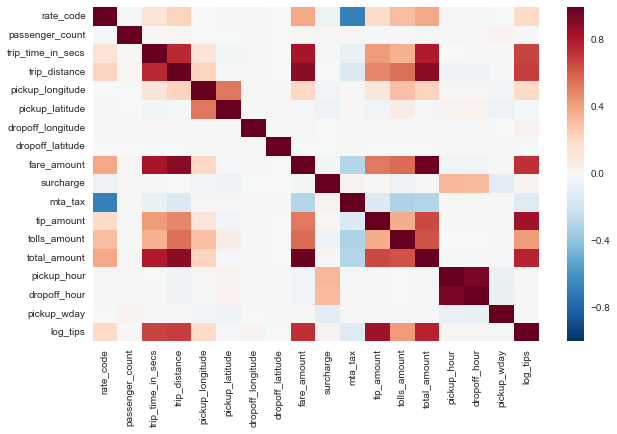

In [8]:
sns.heatmap(sample_trips_df.corr())

In [9]:
sample_trips_non_na['rate_code'].unique()

array([1, 5, 2, 3, 4], dtype=int64)

In [10]:
lm = smf.ols(formula='log_tips ~ tolls_amount + fare_amount + total_amount', data=sample_trips_non_na).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_tips   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                 1.471e+05
Date:                Mon, 06 Jun 2016   Prob (F-statistic):               0.00
Time:                        18:04:42   Log-Likelihood:                 11212.
No. Observations:               96203   AIC:                        -2.242e+04
Df Residuals:                   96199   BIC:                        -2.238e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.0551      0.002     36.137      0.000         0.052     0.058
tolls_amount    -0.1918      0.001   -187.996      0.000        -0.194    -0.190
fare_amount     -0.1499      0.001   -224.404      0.000        -0.151    -0.149
total_amount     0.1665      0.001    295.235      0.000         0.165     0.168
==============================================================================
Omnibus:                   131417.693   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        373448305.170
Skew:                          -6.991   Prob(JB):                         0.00
Kurtosis:                     307.909   Cond. No.                         64.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
lm = smf.ols(formula='log_tips ~ neighborhood + pickup_day', data=sample_trips_non_na).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_tips   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     188.7
Date:                Mon, 06 Jun 2016   Prob (F-statistic):               0.00
Time:                        18:05:56   Log-Likelihood:                -64530.
No. Observations:               96203   AIC:                         1.292e+05
Df Residuals:                   96122   BIC:                         1.300e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------
Intercept                                1.1108      0.034     32.397      0.000         1.044     1.178
neighborhood[T.Astoria Heights]          0.7813      0.047     16.673      0.000         0.689     0.873
neighborhood[T.Battery Park City]       -0.0247      0.037     -0.671      0.503        -0.097     0.047
neighborhood[T.Blissville]              -0.1044      0.131     -0.797      0.426        -0.361     0.152
neighborhood[T.Briarwood]                0.0597      0.171      0.349      0.727        -0.275     0.394
neighborhood[T.Bushwick]                 0.0693      0.141      0.492      0.623        -0.207     0.345
neighborhood[T.Carnegie Hill]           -0.2887      0.035     -8.207      0.000        -0.358    -0.220
neighborhood[T.Central Harlem]          -0.0072      0.109     -0.067      0.947        -0.220     0.206
neighborhood[T.Chelsea]                 -0.2882      0.035     -8.285      0.000        -0.356    -0.220
neighborhood[T.Chinatown]               -0.1760      0.041     -4.333      0.000        -0.256    -0.096
neighborhood[T.Civic Center]            -0.1968      0.037     -5.390      0.000        -0.268    -0.125
neighborhood[T.Clinton]                 -0.2816      0.035     -8.078      0.000        -0.350    -0.213
neighborhood[T.Downtown Flushing]        0.3486      0.214      1.625      0.104        -0.072     0.769
neighborhood[T.Dumbo]                   -0.1032      0.055     -1.884      0.060        -0.210     0.004
neighborhood[T.East Elmhurst]            0.7365      0.035     20.842      0.000         0.667     0.806
neighborhood[T.East Harlem]             -0.1728      0.042     -4.082      0.000        -0.256    -0.090
neighborhood[T.East Village]            -0.2595      0.035     -7.334      0.000        -0.329    -0.190
neighborhood[T.East Williamsburg]       -0.0366      0.055     -0.667      0.505        -0.144     0.071
neighborhood[T.Elmhurst]                 0.1152      0.182      0.632      0.527        -0.242     0.472
neighborhood[T.Financial District]       0.0020      0.036      0.056      0.955        -0.068     0.072
neighborhood[T.Flatiron]                -0.3408      0.035     -9.851      0.000        -0.409    -0.273
neighborhood[T.Forest Hills]             0.3370      0.090      3.729      0.000         0.160     0.514
neighborhood[T.Forest Hills Gardens]     0.7578      0.275      2.751      0.006         0.218     1.298
neighborhood[T.Fulton Ferry]            -0.1784      0.123     -1.448      0.148        -0.420     0.063
neighborhood[T.Glendale]                -0.1991      0.475     -0.419      0.675        -1.129     0.731
neighborhood[T.Gramercy]                -0.3506      0.035     -9.968      0.000        -0.420    -0.282
neighborhood[T.Greenpoint]            

In [15]:
sample_trips_non_na.shape

(96203, 28)

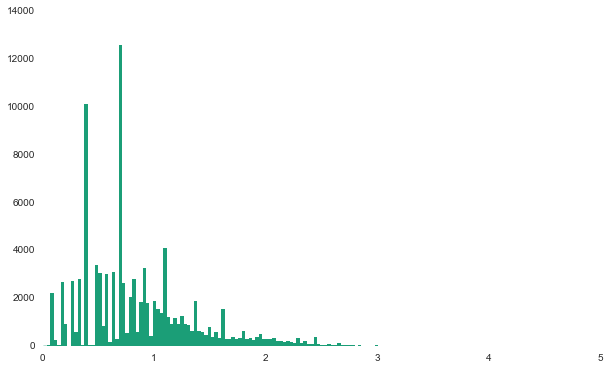

In [16]:
sample_trips_non_na['log_tips'].hist(bins=150)

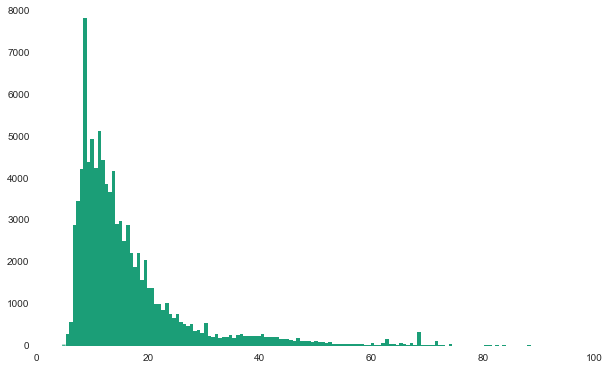

In [17]:
sample_trips_non_na[sample_trips_non_na['total_amount'] < 100]['total_amount'].hist(bins=150)